 Author: Suhan Shetty (suhan.shetty@idiap.ch | suhan.shetty@epfl.ch)
 
 Reference: "Ergodic Control using Tensor Train with Applications in Robotics", Suhan Shetty, Joao Silverio, and Sylvain Calinon

In [1]:
# Dependency: https://github.com/oseledets/ttpy
# !pip install ttpy
# Note: Make sure gfortran(or any other fortran compiler) is installed in your system before executing the above package

In [2]:
import numpy as np
import scipy
from scipy.stats import ortho_group
import scipy.integrate as integrate
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import tt
from tt import riemannian
from tt.cross import rect_cross as tt_cross
import time
from tqdm import tqdm # for-loop progress bar

In [3]:
# State space description:

d = 10 # dimension of the state space (the hyperparameters are set for cases d<15)

# Number of basis functions in each dimension:
K0 = 5 # (recommended) 3 to 5 is enough for most practical usescases. A larger K will demand noisy trajectory and it will
# demand more accurate integration scheme for ttWt in the control loop. Larger K*d demands larger rmax_ (in the control loop)
# which would slow down the control loop. 
K = np.array([K0]*d)

# State space geometry: [0,L]^d
L0 = 1.0 
L = np.array([L0]*d) # Length of each axis
Lmin = 0*L 

print("Number of Fourier coefficients:{}".format(np.prod(K)))


Number of Fourier coefficients:9765625


In [4]:
# Reference probability distribution (GMM) parameters

nmix = 2 # number of mixture components

# Generate randomly mixture coefficients, mean, and covariance of th GMM
c = np.random.uniform(0.25,0.75,nmix)
c = c/np.sum(c) 
mu = np.empty([nmix,d])
sigma = np.empty([nmix,d,d])
for j in range(nmix):
    mu[j,:] = np.random.uniform(0.3*L0,+0.7*L0,d)
    Q = ortho_group.rvs(dim=d)
    s = np.random.uniform(0.01,0.02,d)
    S = np.diag(s)
    sigma[j,:,:] = Q@S@Q.T

In [5]:
print("Mixture Coefficients, c: ",c)
print("\nMean, mu:\n ",mu)

Mixture Coefficients, c:  [0.57600602 0.42399398]

Mean, mu:
  [[0.65545455 0.48225308 0.69530913 0.40808772 0.59313915 0.31779712
  0.55767802 0.63646296 0.65220428 0.54661022]
 [0.30712255 0.53133633 0.64620501 0.50666777 0.6266443  0.58403885
  0.63613108 0.48097052 0.5733095  0.59499963]]


In [6]:
# GMM definition (reference probability distribution)
def p(x):
    result = 0 
    for k in range(nmix):
        n_coef = (np.linalg.det(sigma[k,:,:])*(2*np.pi)**(d))**(-0.5)
        l = 0.5*(x-mu[k,:])@np.linalg.inv(sigma[k,:,:])@(x-mu[k,:]).T
        result = result + c[k]*n_coef*np.exp(-l)
    return result


# Function to keep the trajectory within the ergodic space
def pull2centre(x, alpha=30, c=L/20):
    '''
    c: defines the boundary at which the correction velocity to pull back the systenm\
    to ergodic space activates, smoothly
    alpha: determines the smoothness 
    '''
    c1 = 1*c
    c2 = L-c1
    weight = (np.tanh(alpha*(x-c1)))/2 + (np.tanh(alpha*(c2-x)))/2
    dx = -np.tanh(alpha*(x-c1))/2 +(np.tanh(alpha*(c2-x)))/2
    return weight, dx


# id=1
# t = np.linspace(-1,2,500)
# x = np.random.rand(500,d)
# x[:,id]=t
# sq = 0*x
# pl = 0*x
# ct = -1
# for x_ in x:
#     ct+=1
#     sq[ct,:], pl[ct,:]= pull2centre(x_)

# plt.plot(t,sq[:,id],"--b")
# plt.plot(t,pl[:,id],"--r")

In [7]:
# Define the Fourier basis in tensor-train format

# Define the elmental basis vector (y is a scalar)
Phi  = lambda y, i: np.array([np.cos(np.pi*y*k/L[i])for k in range(K[i])])


# Define derivative of elemental basis vector phi :
DPhi = lambda y, i: (-np.pi/L[i])*np.array([(k)*np.sin(np.pi*y*k/L[i])for k in range(K[i])])

# The followinf function Gives the basis functions for the domain as a tensor in TT fomat and its gradient
# as a rank-1 tensor in TT at any given point x 
def tt_phi_dphi(x):
    d = len(x)
    _Phi = [Phi(x[i],i).reshape(1,-1,1) for i in range(d)]
    _ttPHI = tt.vector.from_list(_Phi)
    _DPhi = [DPhi(x[i],i) for i in range(d)]
    _ttDPHI = []
    for i in range(d):
        tmp = _Phi[:]
        tmp[i] = _DPhi[i].reshape(1,-1,1)
        tt_ = tt.vector.from_list(tmp)
        _ttDPHI.append(tt_)
    return _ttPHI, _ttDPHI    
        

### Pre-processing

In [8]:
# Find the fourier coefficient for an arbitrary distribution using TT (ref [1])
# Use Gaussian Quadrature Rule (GQR) for integration(Ref: https://austingwalters.com/gaussian-quadrature/)
t1 = time.time()

# Get the discretization points and quadrature weights for the domain [-1,1] (standard pipeline for GQR)
N = 10 # 10 is often sufficient. Increase N, if the pdf is not smoothly varying 
x0,w0 = np.polynomial.legendre.leggauss(N)

# transform the discretization points and quadrature weights to the interval [0, L0]:
xn = 0.5*L0*(x0+1.0)
wn = w0*0.5*L0

def P(I): # Discretization of pdf at GQR query points for tt-cross
    I = I.astype(int)
    result = np.zeros(I.shape[0])
    for m,I_ in enumerate(I):
        x = xn[I_]
        w = np.prod(wn[I_])
        result[m]=w*p(x)
    return result

print("Computing Fourier Coefficients, ttW: ")
p_init = tt.rand(N,d,r=1)
ttP = tt_cross.cross(P,x0=p_init,nswp=20,kickrank=1.1,eps=1E-2) 

ttP = ttP.round(1E-2) # for optimal TT represenation do TT-rounding    

# Normalise approximation error, if any
ones_ = tt.vector.from_list([np.ones(N).reshape(1,-1,1)]*d)
residual = tt.dot(ones_,ttP)
ttP = ttP*(1/residual) 
print("\nResidual Error: ",1-residual)

# The scalar fourier basis at each grid point
phi_all = np.zeros([N,K0])
for k in range(K0):
    phi_all[:,k] = np.cos(np.pi*xn*k/L0)

# Determine the Fourier Coefficents in TT format (Use analytical solution from ref [1])
P_l = tt.vector.to_list(ttP)
W = []
for i in range(d):
    P_i = P_l[i]
    W_i = np.empty([P_i.shape[0],K0, P_i.shape[2]])
    for k in range(K0):
        W_i[:,k,:] = np.sum(P_i*(phi_all[:,k].reshape(1,-1,1)),axis=1)
    W.append(W_i) 

ttW = tt.vector.from_list(W) # convert list of TT-cores to tensor in TT

t2 = time.time()  
print("\nRank of ttW: ",ttW.r)
print("\nNumber of Fourier coefficients:{}".format(np.prod(K)))
print("\nTime taken to compute Fourier Coefficient : ",(t2-t1)/60, "minutes")

Computing Fourier Coefficients, ttW: 
swp: 0/19 er_rel = 1.0e+08 er_abs = 2.1e+05 erank = 3.0 fun_eval: 720
swp: 1/19 er_rel = 2.1e-01 er_abs = 4.2e-04 erank = 5.5 fun_eval: 3600
swp: 2/19 er_rel = 7.4e-01 er_abs = 2.2e-03 erank = 8.3 fun_eval: 11280
swp: 3/19 er_rel = 1.0e-01 er_abs = 3.1e-04 erank = 12.7 fun_eval: 28630
swp: 4/19 er_rel = 1.2e-01 er_abs = 3.7e-04 erank = 17.7 fun_eval: 65200
swp: 5/19 er_rel = 4.7e-02 er_abs = 1.4e-04 erank = 22.8 fun_eval: 130880
swp: 6/19 er_rel = 1.5e-02 er_abs = 4.5e-05 erank = 27.9 fun_eval: 233400
swp: 7/19 er_rel = 9.6e-03 er_abs = 2.9e-05 erank = 32.9 fun_eval: 381650

Residual Error:  0.02015180553595375

Rank of ttW:  [ 1  5 11 18 19 21 16 12  7  3  1]

Number of Fourier coefficients:9765625

Time taken to compute Fourier Coefficient :  0.5812079826990764 minutes


Possible reasons for nonzero residual, if any: 
- pdf has some mass outside the ergodic space: not a problem
- the distribution is concentrated in a small region of the space or highly multimodal: increase N
    - If pdf is concnetrated in a small regions, smart way to do ergodic control in such case is to decrease the length of the boundary L small enough to contain the pdf.

In [9]:
# Find the optimization weights in ergodic metric using cross-approximation
def V(I):
    I = I.reshape(-1,d)
    s = (1.0+d)/2.0 
    Vp_ = (1+np.linalg.norm(I,axis=1)**2)**(-s)
    return Vp_

print("Computing Optimization Weights: ")
t1=time.time()
Vp_init = tt.rand(K,d,r=1)
ttV0 = tt_cross.cross(V,x0=Vp_init,nswp=15, kickrank=1,eps=1E-6, verbose=False)
t2=time.time()
print("Rank of the weights: ",ttV0.r)
print("Norm of the weights: ",ttV0.norm())
print("Time taken: ", t2-t1,"seconds")

Computing Optimization Weights: 
Rank of the weights:  [ 1  6 11 11 13 11 13 11 11  5  1]
Norm of the weights:  1.002582352853397
Time taken:  0.07237815856933594 seconds


In [10]:
# Preprocessing:

# Optimally represent Fourier Coef of reference distribution in TT format
ttWp = ttW.round(1E-2)# 1E-2 is sufficient in practice

# Optimization weights in its optimal representation
ttV = ttV0.round(1E-2) # 1E-2 is sufficient in practice

print("Rank of ttWp: {} \nRank of ttV: {} ".format(ttWp.r, ttV.r))

Rank of ttWp: [ 1  4  7  9 11 13 10  8  5  3  1] 
Rank of ttV: [1 2 2 2 2 2 2 2 2 2 1] 


### Ergodic Control Loop

In [11]:
# Ergodic Control Loop

x = L0*np.random.rand(1,d).reshape(-1,) # initial point of the dynamical system, choose any

umax = 5 # Maximum velocity of the point-mass system (umax*dt is the maximum displacement). 

ttWt = 0*tt.rand(ttWp.n,ttWp.d,r=1) #Initialise time-avg stats of dynamical system's trajectory

rmax_ = d*int(np.max(ttWp.r)) # Tune this hyperparamer carefully. This is the maximal upper rank of ttWt.If this is low, 
# there might be convergence issues. If it is too high, the speed of control will be effected.
flush_every = 1 # (tune this) Every these many iterations of control loop, TT-rounding will be applied to ttWt


# Store the trajectory for plotting
traj = [x] 
erg_metric = []


T = 10 # Duration of ergodic exploration
dt = 0.01 # Run at 100Hz
t_ = np.arange(0,T,dt)
ct = 0
tavg = 0
t_iter = tqdm(t_[1:])
for t in t_iter:
    ct +=1

    t1 = time.time()
    
    ttPHI, ttDPHI = tt_phi_dphi(x)
    delta = ttPHI 
    ttWt =  ttWt+delta # Euler integration. This increases the rank of ttWt 
    #ttWt_ = tt.riemannian.projector_splitting_add(ttWt_,delta) # #
    # Ideally, the above integration should be used, but due to a bug in ttpy it does not work as expected
    
    if (ct+1)%flush_every==0: #
        # flush ttWt 
        ttWt = ttWt.round(eps=1E-6,rmax=rmax_)
            
    ttdW = (ttWt-ttWp*ct) 
    ttVdW = ttdW*ttV
    b = np.array([tt.dot(ttVdW,ttDPHI[i]) for i in range(d)])
    bn = np.linalg.norm(b)+1E-10
    erg_ctrl = -(umax/bn)*b # control input from ergodic controller(velocity)

    # Correction velocity to keep the system in the ergodic space [0,1]x...x[0,1]
    weight_,centre_pull = pull2centre(x,alpha=20,c=L/20)
    centre_pull = umax*centre_pull/(np.linalg.norm(centre_pull)+1E-8) 
    
    
    dx = erg_ctrl*weight_ + centre_pull*(1-weight_)
    dx = umax*dx/(np.linalg.norm(dx)+1E-8)
    
    x = np.clip(x+dt*dx,Lmin,L)
    
    if bn<1E-9:
        print("Terminated at ",t)
        break

   
    t2 = time.time()
    
    # For plotting
    dW = ttdW*(1/ct)
    err_ = (ttV*dW).norm()
    erg_metric.append(err_)
    tavg = tavg + (t2-t1)
    traj.append(x)

print("Average time per loop: ", tavg/ct, "sec")
traj = np.array(traj)

100%|██████████| 999/999 [02:05<00:00,  7.96it/s]

Average time per loop:  0.07416907015505496 sec


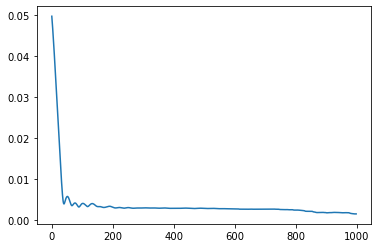

In [12]:
plt.plot(erg_metric[:-1])
# If the loss is diverging away from zero for very large d or large K0:
# increase rmax_ for ttWt.round() (it will slow down the control loop though)

In [13]:
mean_traj = np.sum(traj,axis=0)/traj.shape[0]
mean_act = np.sum(mu*c.reshape(-1,1),axis=0)
error = np.linalg.norm(mean_traj-mean_act)
print("error in expectation: ",error)

error in expectation:  0.007496128141623619


### Plot the results

In [ ]:
import random
plt.style.use('seaborn-white')
fig, ax = plt.subplots(2, 2, sharey=True, sharex=True)
fig.set_figheight(8)
fig.set_figwidth(8)

# Randomly choose axis to plot
a = np.arange(d).tolist()
random.shuffle(a)
ix_ = a[:2]
iy_ = a[2:4]


m = -1 # number of smaples from the trajectory to plot

# Discretize the statespace for plotting
dh0 = 0.01
n_sections = 10 # number of 2D slices for contour plot (increase it for better accuracy of contour plot )

xa = np.arange(Lmin[0],L[0]+dh0,dh0)  # discretize each dimensions
n = [len(xa) for i in range(d)] # number of dscrete states along each dimension
xx,yy = np.meshgrid(xa,xa)
ctx = -1
ix_tqdm = tqdm(ix_)
for ix in ix_tqdm :
    ix_tqdm.set_description("Plotting under progress")
    ctx+=1
    cty=-1
    for iy in iy_:
        cty+=1
        P_ = np.empty([n[ix],n[iy]])
        for i,x_ in enumerate(xa):
            for j,y_ in enumerate(xa): 
                P_[i,j]=0
                for a_ in np.linspace(0,1,n_sections): 
                    x = [a_*L0]*d
                    x[ix] = x_
                    x[iy] = y_
                    P_[i,j] = p(x)+P_[i,j]
        
        ax[ctx,cty].contourf(xa,xa,P_.T, alpha=0.5)
        ax[ctx,cty].plot(traj[0:m,ix],traj[0:m,iy],'-k', linewidth=0.15)
        ax[ctx,cty].set_xlabel("$x_{}$".format({str(ix+1)}),fontsize=12)
        ax[ctx,cty].set_ylabel("$x_{}$".format({str(iy+1)}),fontsize=12)
        ax[ctx,cty].set_xlim([0,L0])
        ax[ctx,cty].set_ylim([0,L0])
        ax[ctx,cty].set_aspect('equal')
        ax[ctx,cty].set_xticks([])
        ax[ctx,cty].set_yticks([])



Plotting under progress:   0%|          | 0/2 [00:00<?, ?it/s]